In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import networkx as nx
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(style="darkgrid")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [5]:
date = '01-03-2024'
d, m, a = date.split('-')
folder = f"{a}-{m}-{d}"
fname_sb = f'/mnt/data/sobe_desce/03_2024/{folder}/output/sobe_desce_{date}_esp.csv'

In [6]:
path_out = '/mnt/data/origin_destination/new_nf/'

## Grafo

In [11]:
# load grph
#G = nx.read_gpickle('/mnt/data/origin_destination/gtfs_bus_add_lines_09_2023.gpickle')
G = nx.read_gpickle('../data/graph_designer/graph_gtfs_fev_2024.gpickle')

In [12]:
G.is_directed()

True

In [13]:
# create adjacency matrix
A = nx.adjacency_matrix(G, weight='distance')
a_sparse = A.todense()
A.shape, a_sparse.shape, type(a_sparse)

((2871, 2871), (2871, 2871), numpy.matrix)

In [14]:
# Get the nodes of the graph
nodes = list(G.nodes())

# Print the nodes and their corresponding indices in the adjacency matrix
for i, node in enumerate(nodes[:3]):
    print(f"Node {node} is at index {i} in the adjacency matrix")

Node 100009577 is at index 0 in the adjacency matrix
Node 345936831 is at index 1 in the adjacency matrix
Node 100722777 is at index 2 in the adjacency matrix


## Trip Time Series

In [16]:
tts = pd.read_parquet(f'/mnt/data/sobe_desce/03_2024/{folder}/output/trips_time-series_{date}_{date}.parquet')
tts.head()

,linha_atend,linha,cod_ate,sentido,shape,ordem,stop_id,lat,lon,distancias,acumulado,posicao,veiculo,trip,trip_id,inicio_viagem,fim_viagem,set,hora_ponto,saida,fill,tempo_parada,duracao,tempo_total,tempo_parada_acum,duracao_acum,distancia,dis_acum,vm,vm_acum,type
0,123101_57892,123101,57892,I,57892_I,1,44782944,-12.942813,-38.438602,0.000,0.000,inicial,21224,1.0,21224_123101_1,2024-03-01 05:30:58,2024-03-01 06:51:28,ottrans,2024-03-01 05:30:58,2024-03-01 05:30:58,False,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,bus
1,123101_57892,123101,57892,I,57892_I,2,44784618,-12.939712,-38.438862,0.449,0.449,intermediario,21224,1.0,21224_123101_1,2024-03-01 05:30:58,2024-03-01 06:51:28,ottrans,2024-03-01 05:32:18,2024-03-01 05:32:25,False,7.0,80.0,87.0,7.0,80.0,0.345999,0.000000,15.569937,0.000000,bus
2,123101_57892,123101,57892,I,57892_I,3,44784340,-12.938302,-38.439884,0.126,0.575,intermediario,21224,1.0,21224_123101_1,2024-03-01 05:30:58,2024-03-01 06:51:28,ottrans,2024-03-01 05:32:46,2024-03-01 05:33:22,False,36.0,21.0,57.0,43.0,101.0,0.191938,0.345999,32.903659,12.332624,bus
3,123101_57892,123101,57892,I,57892_I,4,44782337,-12.935150,-38.440578,0.523,1.098,intermediario,21224,1.0,21224_123101_1,2024-03-01 05:30:58,2024-03-01 06:51:28,ottrans,2024-03-01 05:35:31,2024-03-01 05:36:03,False,32.0,129.0,161.0,75.0,230.0,0.358460,0.537937,10.003548,8.419877,bus
4,123101_57892,123101,57892,I,57892_I,5,44784470,-12.937017,-38.437576,0.417,1.515,intermediario,21224,1.0,21224_123101_1,2024-03-01 05:30:58,2024-03-01 06:51:28,ottrans,2024-03-01 05:36:50,2024-03-01 05:37:07,False,17.0,47.0,64.0,92.0,277.0,0.385962,0.896397,29.563075,11.649926,bus


In [17]:
tts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739370 entries, 0 to 739369
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   linha_atend        739370 non-null  object        
 1   linha              739370 non-null  object        
 2   cod_ate            739370 non-null  object        
 3   sentido            739370 non-null  object        
 4   shape              739370 non-null  object        
 5   ordem              739370 non-null  int64         
 6   stop_id            739370 non-null  object        
 7   lat                739370 non-null  float64       
 8   lon                739370 non-null  float64       
 9   distancias         739370 non-null  float64       
 10  acumulado          739370 non-null  float64       
 11  posicao            739370 non-null  object        
 12  veiculo            739266 non-null  object        
 13  trip               739266 non-null  float64 

In [18]:
tts['vm'].describe()

count    7.392820e+05
mean              inf
std               NaN
min     -7.389536e+03
25%      1.639009e+01
50%      2.607927e+01
75%      3.885914e+01
max               inf
Name: vm, dtype: float64

In [19]:
tts['vm'][tts['vm'] < 0] = pd.NA
tts['vm'][tts['vm'] > 80] = pd.NA

In [20]:
tts[tts['vm'].isna()].shape

(19505, 31)

In [21]:
tts['vm'] = tts['vm'].fillna(method='ffill')

In [22]:
tts[tts['vm'].isna()].shape

(0, 31)

<AxesSubplot:>

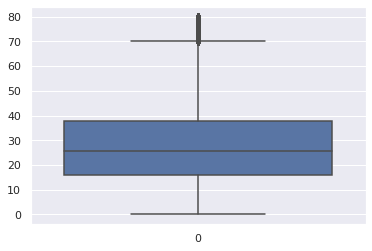

In [23]:
sns.boxplot(tts['vm'].values)

In [24]:
tts['vm'].describe()

count    739370.000000
mean         27.401336
std          15.526595
min           0.000000
25%          16.048815
50%          25.521551
75%          37.737479
max          79.997615
Name: vm, dtype: float64

In [25]:
tts[tts['vm'].isna()].shape

(0, 31)

<AxesSubplot:>

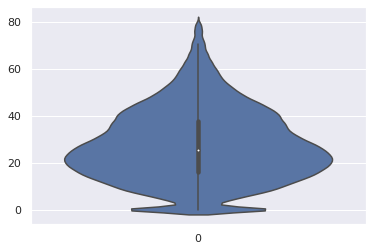

In [28]:
sns.violinplot(tts['vm'].values)

<AxesSubplot:ylabel='Count'>

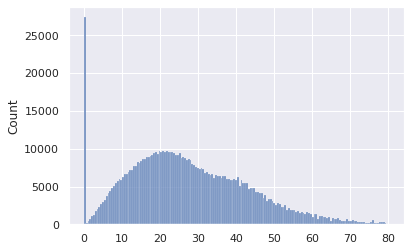

In [29]:
sns.histplot(tts['vm'].values)

In [30]:
tts.dis_acum.describe()

count    739370.000000
mean          7.942860
std           6.938332
min           0.000000
25%           2.309278
50%           6.046421
75%          12.036990
max          32.343860
Name: dis_acum, dtype: float64

In [31]:
tts.shape, tts.query(" vm < 0  ").shape, tts.query(" vm > 0 and vm < 80 ").shape

((739370, 31), (0, 31), (712022, 31))

In [32]:
tts.query(" vm > 0  ").vm.describe()

count    712022.000000
mean         28.453792
std          14.845477
min           0.057502
25%          17.168200
50%          26.258123
75%          38.273506
max          79.997615
Name: vm, dtype: float64

In [33]:
tts.query(" vm > 0 and vm < 80 ").vm.describe()

count    712022.000000
mean         28.453792
std          14.845477
min           0.057502
25%          17.168200
50%          26.258123
75%          38.273506
max          79.997615
Name: vm, dtype: float64

In [34]:
#sns.boxplot(tts.query(" tempo_total > 0 and tempo_total < 240 ").vm.values)
#sns.boxplot(tts.query(" vm > 0 and vm < 80 and tempo_total > 0  ").tempo_total.values)

In [35]:
def insert_faixa(
    fpath: str, 
    date: str, 
    freq=5
    ) -> tuple:
    
    df = pd.read_csv(fpath)
    # convert to datetime
    df.hora_ponto = pd.to_datetime(df.hora_ponto, format='%Y-%m-%d %H:%M:%S')
    # 
    min_time_str = f"{date} 05:00:00"
    max_time_str = f"{date} 00:59:59"
    # convert to datetime instance
    min_datetime = datetime.strptime(min_time_str, '%Y-%m-%d %H:%M:%S')
    max_datetime = datetime.strptime(max_time_str, '%Y-%m-%d %H:%M:%S')
    max_datetime = max_datetime + timedelta(days=1)
    
    print(f"[{min_datetime}, {max_datetime}]")
    
    # create intervals by frequency
    interval = freq
    intervals = []
    generation = True
    intervals.append(min_datetime)
    count = 0
    while generation:
        lag = intervals[-1]
        new = lag + timedelta(minutes=interval)
        if new <= max_datetime:
            intervals.append(new)
        else:
            generation = False
            print(f"End generation: {new}")
        count +=1
    print(f"Intervals: {count}")
    intervals_pairs = [[intervals[i], intervals[i+1]] for i in range(len(intervals)-1)]
    df['interval'] = pd.NaT
    for inter in tqdm(intervals_pairs):
        i, j = inter
        df['interval'][(df.hora_ponto >= i) & (df.hora_ponto < j)] = i
    # drop na
    df = df[~df.interval.isna()]
    
    #df_loader_faixa = df.pivot_table(index=['interval', 'ponto'], values='carregamento', aggfunc='sum', dropna=False).reset_index()
    #df_loader_faixa = df.pivot_table(index=['interval', 'ponto'], values='carregamento_fit', aggfunc='sum', dropna=False).reset_index()
    
    return df, intervals

In [36]:
df_day, inter = insert_faixa(fpath=fname_sb, 
                      date=f'{a}-{m}-{d}', 
                      freq=5)

[2024-03-01 05:00:00, 2024-03-02 00:59:59]
End generation: 2024-03-02 01:00:00
Intervals: 240


100% 239/239 [00:01<00:00, 238.15it/s]


In [37]:
df_day = df_day.astype({'ponto': str})
#nf = df_day.pivot_table(index='interval', columns='ponto', values='carregamento_fit', aggfunc='sum').reset_index()

In [38]:
df_day

,index,linha,cod_ate,sentido,ordem,ponto,veiculo,trip,trip_id,inicio_viagem,fim_viagem,set,hora_ponto,sobe,desce,lag_carregamento,saldo,carregamento,sobe_fit,lag_carregamento_fit,desce_fit,saldo_fit,carregamento_fit,percent_desce,percent_sobe_esp,sobe_especie,sobe_total_especie,lag_carregamento_especie,desce_total_especie,saldo_especie,carregamento_especie,percent_desce_fit,interval
50,569,1035,53299,I,1,43787620,21225,2,21225_1035_2,2024-03-01 05:16:38,2024-03-01 07:05:11,ottrans,2024-03-01 05:16:38,3.0,0.0,0,0,3,3.0,0.000000,0.0,0.000000,3.000000,0.0,0.154004,0.608316,3.608316,0.000000,0.0,0.000000,3.608316,0.0,2024-03-01 05:15:00
51,570,1035,53299,I,2,215205049,21225,2,21225_1035_2,2024-03-01 05:16:38,2024-03-01 07:05:11,ottrans,2024-03-01 05:19:23,0.0,0.0,3,3,3,0.0,3.000000,0.0,3.000000,3.000000,0.0,0.000000,0.000000,0.000000,3.608316,0.0,3.608316,3.608316,0.0,2024-03-01 05:15:00
52,571,1035,53299,I,3,45833922,21225,2,21225_1035_2,2024-03-01 05:16:38,2024-03-01 07:05:11,ottrans,2024-03-01 05:20:52,2.0,0.0,3,3,5,3.0,3.000000,0.0,3.000000,6.000000,0.0,0.154004,0.608316,3.608316,3.608316,0.0,3.608316,7.216632,0.0,2024-03-01 05:20:00
53,572,1035,53299,I,4,120548519,21225,2,21225_1035_2,2024-03-01 05:16:38,2024-03-01 07:05:11,ottrans,2024-03-01 05:21:45,0.0,0.0,5,5,5,1.0,6.000000,0.0,6.000000,7.000000,0.0,0.051335,0.202772,1.202772,7.216632,0.0,7.216632,8.419405,0.0,2024-03-01 05:20:00
54,573,1035,53299,I,5,44782596,21225,2,21225_1035_2,2024-03-01 05:16:38,2024-03-01 07:05:11,ottrans,2024-03-01 05:23:59,3.0,0.0,5,5,8,5.0,7.000000,0.0,7.000000,12.000000,0.0,0.256674,1.013860,6.013860,8.419405,0.0,8.419405,14.433265,0.0,2024-03-01 05:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739261,599911,933,53413,V,72,45833241,20030,6,20030_0933_6,2024-03-01 19:33:20,2024-03-01 20:50:57,ottrans,2024-03-01 20:47:29,0.0,0.0,7,7,7,0.0,8.689476,0.0,8.689476,8.689476,0.0,0.000000,0.000000,0.000000,9.427301,0.0,9.427301,9.427301,0.0,2024-03-01 20:45:00
739262,599912,933,53413,V,73,44784172,20030,6,20030_0933_6,2024-03-01 19:33:20,2024-03-01 20:50:57,ottrans,2024-03-01 20:49:43,0.0,0.0,7,7,7,0.0,8.689476,0.0,8.689476,8.689476,0.0,0.000000,0.000000,0.000000,9.427301,0.0,9.427301,9.427301,0.0,2024-03-01 20:45:00
739263,599913,933,53413,V,74,44784207,20030,6,20030_0933_6,2024-03-01 19:33:20,2024-03-01 20:50:57,ottrans,2024-03-01 20:50:08,0.0,0.0,7,7,7,0.0,8.689476,0.0,8.689476,8.689476,0.0,0.000000,0.000000,0.000000,9.427301,0.0,9.427301,9.427301,0.0,2024-03-01 20:50:00
739264,599914,933,53413,V,75,44783418,20030,6,20030_0933_6,2024-03-01 19:33:20,2024-03-01 20:50:57,ottrans,2024-03-01 20:50:39,0.0,0.0,7,7,7,0.0,8.689476,0.0,8.689476,8.689476,0.0,0.000000,0.000000,0.000000,9.427301,0.0,9.427301,9.427301,0.0,2024-03-01 20:50:00


In [39]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731913 entries, 50 to 739265
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   index                     731913 non-null  int64         
 1   linha                     731913 non-null  object        
 2   cod_ate                   731913 non-null  int64         
 3   sentido                   731913 non-null  object        
 4   ordem                     731913 non-null  int64         
 5   ponto                     731913 non-null  object        
 6   veiculo                   731913 non-null  int64         
 7   trip                      731913 non-null  int64         
 8   trip_id                   731913 non-null  object        
 9   inicio_viagem             731913 non-null  object        
 10  fim_viagem                731913 non-null  object        
 11  set                       731913 non-null  object        
 12  h

In [40]:
dfs = []
for node in nodes:
    df_node =  pd.DataFrame()
    df_node['time'] = inter
    df_node['node'] = node
    dfs.append(df_node)

In [41]:
df_nodes_src = pd.concat(dfs, ignore_index=True)
df_nodes_src.head()

,time,node
0,2024-03-01 05:00:00,100009577
1,2024-03-01 05:05:00,100009577
2,2024-03-01 05:10:00,100009577
3,2024-03-01 05:15:00,100009577
4,2024-03-01 05:20:00,100009577


In [42]:
print(f"num nodes in df ..: {A.shape}")
print(f"num nodes in A ...: {df_nodes_src.node.nunique()}")

num nodes in df ..: (2871, 2871)
num nodes in A ...: 2871


## fill with values

In [43]:
df_dasb_trainy.shape, tts.shape

((731913, 33), (739370, 31))

In [44]:
tts = tts.rename({'stop_id': 'ponto'}, axis=1)

In [45]:
df_day_vm = df_day.merge(tts[['trip_id', 'sentido', 'ordem', 'ponto', 'vm']], 
                         on=['trip_id', 'sentido', 'ordem', 'ponto'], how='left')

In [46]:
df_day_vm.shape

(731913, 34)

In [47]:
df_day_vm.head()

,index,linha,cod_ate,sentido,ordem,ponto,veiculo,trip,trip_id,inicio_viagem,fim_viagem,set,hora_ponto,sobe,desce,lag_carregamento,saldo,carregamento,sobe_fit,lag_carregamento_fit,desce_fit,saldo_fit,carregamento_fit,percent_desce,percent_sobe_esp,sobe_especie,sobe_total_especie,lag_carregamento_especie,desce_total_especie,saldo_especie,carregamento_especie,percent_desce_fit,interval,vm
0,569,1035,53299,I,1,43787620,21225,2,21225_1035_2,2024-03-01 05:16:38,2024-03-01 07:05:11,ottrans,2024-03-01 05:16:38,3.0,0.0,0,0,3,3.0,0.0,0.0,0.0,3.0,0.0,0.154004,0.608316,3.608316,0.000000,0.0,0.000000,3.608316,0.0,2024-03-01 05:15:00,0.000000
1,570,1035,53299,I,2,215205049,21225,2,21225_1035_2,2024-03-01 05:16:38,2024-03-01 07:05:11,ottrans,2024-03-01 05:19:23,0.0,0.0,3,3,3,0.0,3.0,0.0,3.0,3.0,0.0,0.000000,0.000000,0.000000,3.608316,0.0,3.608316,3.608316,0.0,2024-03-01 05:15:00,24.186356
2,571,1035,53299,I,3,45833922,21225,2,21225_1035_2,2024-03-01 05:16:38,2024-03-01 07:05:11,ottrans,2024-03-01 05:20:52,2.0,0.0,3,3,5,3.0,3.0,0.0,3.0,6.0,0.0,0.154004,0.608316,3.608316,3.608316,0.0,3.608316,7.216632,0.0,2024-03-01 05:20:00,69.046729
3,572,1035,53299,I,4,120548519,21225,2,21225_1035_2,2024-03-01 05:16:38,2024-03-01 07:05:11,ottrans,2024-03-01 05:21:45,0.0,0.0,5,5,5,1.0,6.0,0.0,6.0,7.0,0.0,0.051335,0.202772,1.202772,7.216632,0.0,7.216632,8.419405,0.0,2024-03-01 05:20:00,25.422257
4,573,1035,53299,I,5,44782596,21225,2,21225_1035_2,2024-03-01 05:16:38,2024-03-01 07:05:11,ottrans,2024-03-01 05:23:59,3.0,0.0,5,5,8,5.0,7.0,0.0,7.0,12.0,0.0,0.256674,1.013860,6.013860,8.419405,0.0,8.419405,14.433265,0.0,2024-03-01 05:20:00,45.512501


In [48]:
nf_loader = df_day.pivot_table(index=['interval', 'ponto'], 
                        values='carregamento', 
                        aggfunc='sum').reset_index()

In [49]:
# sobe
nf_sobe = df_day.pivot_table(index=['interval', 'ponto'], 
                        values='sobe', 
                        aggfunc='sum').reset_index()
# desce
nf_desce = df_day.pivot_table(index=['interval', 'ponto'], 
                        values='desce', 
                        aggfunc='sum').reset_index()
# veiculos
nf_veic = df_day.pivot_table(index=['interval', 'ponto'], 
                        values='veiculo', 
                        aggfunc=pd.Series.nunique).reset_index()
# linhas
nf_lines = df_day.pivot_table(index=['interval', 'ponto'], 
                        values='linha', 
                        aggfunc=pd.Series.nunique).reset_index()
# viagens
nf_trips = df_day.pivot_table(index=['interval', 'ponto'], 
                        values='trip_id', 
                        aggfunc=pd.Series.nunique).reset_index()


In [50]:
# vm
nf_vm = df_day_vm.pivot_table(index=['interval', 'ponto'], 
                        values='vm', 
                        aggfunc='mean').reset_index()

In [51]:
df_nodes_src_add =  df_nodes_src.copy()
df_nodes_src_add = df_nodes_src_add.rename({'time': 'interval', 'node': 'ponto'}, axis=1)

In [52]:
# carregamento
df_nodes_src_add = df_nodes_src_add.merge(nf_loader, on=['interval', 'ponto'], how='left')
# sobe
df_nodes_src_add = df_nodes_src_add.merge(nf_sobe, on=['interval', 'ponto'], how='left')

# desce
df_nodes_src_add = df_nodes_src_add.merge(nf_desce, on=['interval', 'ponto'], how='left')

# veiculos
df_nodes_src_add = df_nodes_src_add.merge(nf_veic, on=['interval', 'ponto'], how='left')
#linhas
df_nodes_src_add = df_nodes_src_add.merge(nf_lines, on=['interval', 'ponto'], how='left')
# viagens
df_nodes_src_add = df_nodes_src_add.merge(nf_trips, on=['interval', 'ponto'], how='left')

In [53]:
df_nodes_src_add = df_nodes_src_add.merge(nf_vm, on=['interval', 'ponto'], how='left')

In [56]:
df_nodes_src_add

,interval,ponto,carregamento,sobe,desce,veiculo,linha,trip_id,vm
0,2024-03-01 05:00:00,100009577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-03-01 05:05:00,100009577,14.0,1.0,0.0,2.0,2.0,2.0,0.0
2,2024-03-01 05:10:00,100009577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-03-01 05:15:00,100009577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-03-01 05:20:00,100009577,2.0,2.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
689035,2024-03-02 00:35:00,99834783,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689036,2024-03-02 00:40:00,99834783,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689037,2024-03-02 00:45:00,99834783,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689038,2024-03-02 00:50:00,99834783,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
df_nf_time = df_nodes_src_add.fillna(0)[200:210]

In [112]:
df_nf_time

,interval,ponto,carregamento,sobe,desce,veiculo,linha,trip_id,vm
200,2024-03-01 21:40:00,100009577,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201,2024-03-01 21:45:00,100009577,0.0,0.0,0.0,1.0,1.0,1.0,0.0
202,2024-03-01 21:50:00,100009577,1.0,0.0,0.0,1.0,1.0,1.0,0.0
203,2024-03-01 21:55:00,100009577,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,2024-03-01 22:00:00,100009577,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205,2024-03-01 22:05:00,100009577,0.0,0.0,0.0,1.0,1.0,1.0,0.0
206,2024-03-01 22:10:00,100009577,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207,2024-03-01 22:15:00,100009577,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,2024-03-01 22:20:00,100009577,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,2024-03-01 22:25:00,100009577,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
df_nf_time = df_nf_time.rename(re_nf, axis=1)

In [108]:
df_nf_time.to_csv('nf_time.csv', index=False)

In [59]:
df_nodes_src_add_sub = df_nodes_src_add.copy()#.query(" interval < '2023-11-01 22:00:00' ")
df_nodes_src_add_sub.shape, df_nodes_src_add.shape

((689040, 9), (689040, 9))

In [60]:
df_features = df_nodes_src_add_sub.pivot_table(index='ponto', 
                                               values=['carregamento','sobe','desce','veiculo','linha','trip_id','vm'], 
                                               aggfunc='mean').reset_index()

In [61]:
df_features

,ponto,carregamento,desce,linha,sobe,trip_id,veiculo,vm
0,100009577,2.772152,0.000000,1.075949,0.227848,1.101266,1.101266,6.308304
1,100722777,28.541176,4.429412,1.535294,4.488235,1.564706,1.564706,22.863109
2,100722778,36.715976,1.390533,1.834320,0.100592,2.041420,2.041420,16.061617
3,101214305,12.532258,3.967742,1.000000,1.661290,1.000000,1.000000,19.946498
4,101269104,125.568182,3.545455,4.568182,9.481818,5.277273,5.277273,38.246687
...,...,...,...,...,...,...,...,...
2855,99834780,13.016393,0.622951,1.000000,0.393443,1.065574,1.065574,19.519774
2856,99834781,13.032258,0.693548,1.000000,0.241935,1.048387,1.048387,23.135766
2857,99834782,5.172414,0.034483,1.000000,0.310345,1.103448,1.103448,17.801957
2858,99834783,6.915254,0.033898,1.000000,1.864407,1.084746,1.084746,24.599106


In [99]:
re_nf = {'ponto': 'node', 
         'carregamento': 'loading', 
         'desce':'n-alighting', 
         'linha': 'n-routes', 
         'sobe': 'n-boarding', 
         'trip_id': 'n-trips', 
         'veiculo': 'n-vehicles',
         'vm': 'average_speed'}

In [100]:
df_features_not_tempo = df_features.rename(re_nf, axis=1)

In [101]:
df_features_not_tempo[re_nf.values()][:5].round(2).to_csv('node_features_not_time.csv', index=False)

In [62]:
df_features['target'] = 'sem_info'

In [63]:
df_features['target'][df_features.query(" vm == 0 ").index] = 'parado'
df_features['target'][df_features.query(" vm > 0 and vm <= 5 ").index] = 'congestionado'
df_features['target'][df_features.query(" vm > 5 and vm <= 10 ").index] = 'devagar'
df_features['target'][df_features.query(" vm > 10 and vm <= 40 ").index] = 'normal'
df_features['target'][df_features.query(" vm > 40  ").index] = 'livre'

In [64]:
df_features['target'].value_counts(dropna=False)

normal           2460
livre             300
devagar            82
congestionado      17
parado              1
Name: target, dtype: int64

In [65]:
df_arestas = df_day_vm.copy()

In [66]:
df-

In [67]:
dfs = []
for trip_id, df_trip_id in tqdm(df_arestas.groupby('trip_id')):
    
    df_trip_id['dst']     = df_trip_id['src'].shift(-1)
    df_trip_id['vm_edge'] = df_trip_id['vm'].shift(-1)
    df_trip_id['loader'] = df_trip_id['carregamento'].shift(-1)
    
    df_tpi_fix = df_trip_id.dropna()
    
    dfs.append(df_tpi_fix[['src', 'dst', 'vm_edge', 'loader']])
    

100% 22780/22780 [01:05<00:00, 347.81it/s]


In [68]:
df_edges = pd.concat(dfs, ignore_index=True)
df_edges.head()

,src,dst,vm_edge,loader
0,44782849,47567835,31.900722,31.0
1,47567835,44783952,45.717688,40.0
2,44783952,44784227,19.318384,38.0
3,44784227,44783495,32.261915,39.0
4,44783495,88229436,24.513996,62.0


In [69]:
df_edges_unique = df_edges.pivot_table(index=['src', 'dst'], 
                                       values=['vm_edge', 'loader'], 
                                       aggfunc='mean').reset_index()

In [70]:
df_edges_unique.head()

,src,dst,loader,vm_edge
0,100009577,345936831,2.770115,29.946355
1,100722777,100722778,18.540541,15.494709
2,100722777,44782645,5.820513,10.865240
3,100722777,45833440,23.023810,16.153585
4,100722777,66771046,21.500000,14.545003


In [71]:
df_edges_unique.shape

(4458, 4)

In [72]:
df_edges_unique.loader.describe()

count    4458.000000
mean       15.071712
std         7.122518
min         0.000000
25%         9.900410
50%        14.711382
75%        19.787851
max        64.000000
Name: loader, dtype: float64

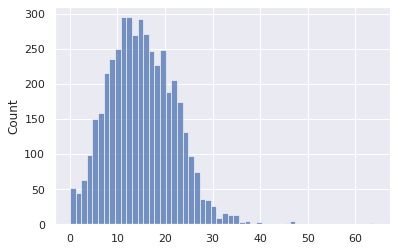

In [87]:
sns.histplot(df_edges_unique.loader.values)
plt.show()

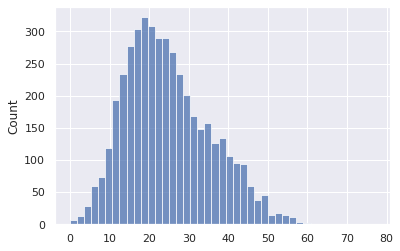

In [73]:
sns.histplot(df_edges_unique.vm_edge.values)
plt.show()

In [74]:
df_edges_unique.query("vm_edge <= 0  ")

,src,dst,loader,vm_edge
1089,44164986,45833922,0.000000,0.0
1296,44675766,44165231,4.727273,0.0


In [75]:
df_edges_unique.shape, df_edges.shape

((4458, 4), (708934, 4))

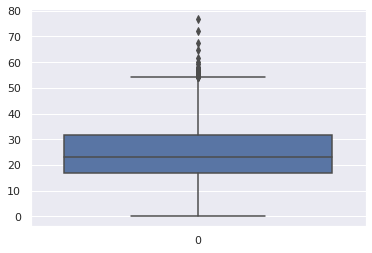

In [76]:
sns.boxplot(df_edges_unique.vm_edge.values)
plt.show()

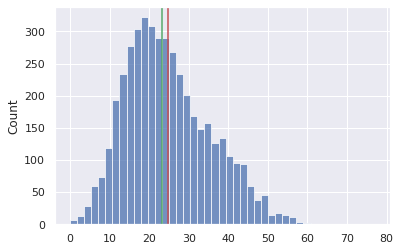

In [77]:
# normal
sns.histplot(df_edges_unique.vm_edge.values)
plt.axvline(np.mean(df_edges_unique.vm_edge.values), c='r')
plt.axvline(np.median(df_edges_unique.vm_edge.values), c='g')
plt.show()

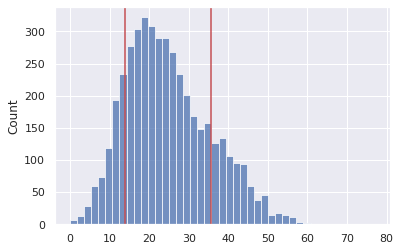

In [88]:
values = df_edges_unique.vm_edge.values
tresh_i  = np.mean(values) - np.std(values)
tresh_ii = np.mean(values) + np.std(values)
sns.histplot(df_edges_unique.vm_edge.values)
plt.axvline(tresh_i, c='r')
plt.axvline(tresh_ii, c='r')
plt.show()

In [79]:
df_edges_unique.vm_edge.describe()

count    4458.000000
mean       24.785758
std        10.810643
min         0.000000
25%        16.785481
50%        23.250201
75%        31.701797
max        76.885414
Name: vm_edge, dtype: float64

In [80]:
# df_edges_unique['target'] = 'sem_classe'
# df_edges_unique['target'][df_edges_unique.query(" vm_edge == 0 ").index] = 'parado'
# df_edges_unique['target'][df_edges_unique.query(" vm_edge >= 0 and vm_edge <= 16 ").index] = 'devagar'
# df_edges_unique['target'][df_edges_unique.query(" vm_edge > 16 and vm_edge <= 25 ").index] = 'normal'
# df_edges_unique['target'][df_edges_unique.query(" vm_edge > 25 and vm_edge <= 31 ").index] = 'fludo'
# df_edges_unique['target'][df_edges_unique.query(" vm_edge > 31 ").index] = 'livre'

In [89]:
df_edges_unique['target'] = 'sem_classe'
df_edges_unique['target'][df_edges_unique.query(f" vm_edge  <= {tresh_i} ").index] = 'devagar'
df_edges_unique['target'][df_edges_unique.query(f" vm_edge > {tresh_i} and vm_edge <= {tresh_ii} ").index] = 'normal'
df_edges_unique['target'][df_edges_unique.query(f" vm_edge > {tresh_ii} ").index] = 'fluido'

In [90]:
df_edges_unique.target.value_counts(dropna=False)

normal     2998
fluido      781
devagar     679
Name: target, dtype: int64

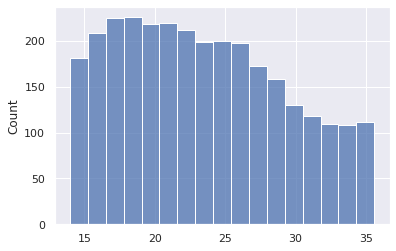

In [91]:
# normal
sns.histplot(df_edges_unique.query(" target == 'normal' ").vm_edge.values)
plt.show()

In [83]:
df_edges_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   src      4458 non-null   object 
 1   dst      4458 non-null   object 
 2   loader   4458 non-null   float64
 3   vm_edge  4458 non-null   float64
 4   target   4458 non-null   object 
dtypes: float64(2), object(3)
memory usage: 174.3+ KB


In [84]:
df_features.ponto.nunique(), df_edges_unique.src.nunique(), df_edges_unique.dst.nunique()

(2860, 2859, 2859)

In [92]:
#df_features.to_parquet('df_features.parquet', index=False)
df_edges_unique.to_parquet('df_edges.parquet', index=False)

In [93]:
df_edges_unique.target.value_counts(dropna=False)

normal     2998
fluido      781
devagar     679
Name: target, dtype: int64